In [1]:
# import knihoven
import numpy as np # lineární algebra, počítání s vektory, maticemi
from matplotlib import pyplot as plt # vizualizace grafů, obrázků
import pandas as pd # v tomto programu pouze načtení dat, obecně nástroj pro manipulaci s daty
from random import randint

In [2]:
data_pd = pd.read_csv('train.csv') # načtení tréninkových dat pomocí pandas

In [4]:
data_pd.head() # zobrazení dat 

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data = np.array(data_pd) # převod dat z pandas dataframe do numpy array (matice)
np.random.shuffle(data) # náhodně zamíchá data
m, n = np.shape(data) # m - počet řádků (záznamů), n - počet sloupců (pixely (vstupní data) + label (správná výstupní hodnota))

# rozdělení dat na trénovací a vývojová data, aby nedošlo k overfittingu

# development set (prvních 1000 řádků), 0 - 1000 bez 1000. záznamu
data_dev = data[0:1000].T # .T - transponováno - jeden záznam je nyní jeden sloupec, ne řádek (nutné pro správné násobení matic)
Y_dev = data_dev[0] # správné výstupní hodnoty Y (label), [řádky, sloupce], stejný zápis - [0,:] (nultý řádek a všechny sloupce)
X_dev = data_dev[1:n] # pixely
X_dev = X_dev / 255

# training set (zbývající řádky)
data_train = data[1000:m].T #data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255

In [4]:
# počáteční vytvoření náhodných parametrů
def inicializace_parametru():
    W1 = np.random.rand(16, 784) - 0.5 
    # váhové koeficienty první vrstvy
    # matice o rozměrech 10 × 784 (každý vstup (pixel) propojený s každým neuronem 1. vrstvy)
    # np.random.rand - rozsah [0, 1), - 0.5 -> rozsah [-0.5, 0.5)
    b1 = np.random.rand(16,1) - 0.5 # prahové hodnoty první vrstvy (pro každý neuron 1. vrstvy 1)
    W2 = np.random.rand(16, 16) - 0.5 # váhy 2. vrstvy (každý neuron z 1. vrstvy propojen s každým neuronem ze 2. vrstvy)
    b2 = np.random.rand(16, 1) - 0.5 # prahy 2. vrstvy (pro každý neuron 2. vrstvy 1)
    W3 = np.random.rand(10, 16) - 0.5 # váhy 3. vrstvy
    b3 = np.random.rand(10, 1) - 0.5 # prahy 3. vrstvy
    return W1, b1, W2, b2, W3, b3

In [5]:
# dopředná propagace

def ReLU(X, derivace = False):
    if derivace:
        return X > 0 # větší než 1 -> true -> 1, menší než 0 -> false -> 0
    return np.maximum(0, X)

def ReLU_rozepsane(X):
    if X <= 0:
        v = 0
    else:
        v = X
    return v

def softmax(X):
    return np.exp(X) / sum(np.exp(X))

def dopredna_propagace(W1, b1, W2, b2, W3, b3, X): 
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = ReLU(Z2)
    Z3 = W3.dot(A2) + b3
    A3 = softmax(Z3)
    return Z1, A1, Z2, A2, Z3, A3

In [6]:
# Zpětná propagace

def zakoduj_odpoved(Y):
    zakodovana_odpoved = np.zeros((Y.size, Y.max() + 1)) # matice (počet záznamů × největší záznam (9) + 1)
    zakodovana_odpoved[np.arange(Y.size), Y] = 1
    zakodovana_odpoved = zakodovana_odpoved.T
    return zakodovana_odpoved

def zpetna_propagace(Z1, A1, Z2, W2, A2, W3, A3, X, Y):
    m = Y.size
    Y = zakoduj_odpoved(Y)
    
    dZ3 = A3 - Y
    dW3 = 1 / m * dZ3.dot(A2.T)
    db3 = 1 / m * np.sum(dZ3)
    
    dZ2 = W3.T.dot(dZ3) * ReLU(Z2, derivace = True)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    
    dZ1 = W2.T.dot(dZ2) * ReLU(Z1, derivace = True)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    
    return dW1, db1, dW2, db2, dW3, db3

def uprava_parametru(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    W3 = W3 - alpha * dW3
    b3 = b3 - alpha * db3
    return W1, b1, W2, b2, W3, b3

In [7]:
def test_samostatne(index, W1, b1, W2, b2, W3, b3, X, Y):
    obrazek = X[:, index, None]
    _, _, _, _, _, A3 = dopredna_propagace(W1, b1, W2, b2, W3, b3, obrazek)
    odhad = odhady(A3)
    print('Odhad: ', odhad)
    print('Správné: ', Y[index])
    
    obrazek = obrazek.reshape(28,28) * 255
    plt.gray()
    plt.imshow(obrazek)
    plt.show()
    
def test(W1, b1, W2, b2, W3, b3, X, Y):
    _, _, _, _, _, A3 = dopredna_propagace(W1, b1, W2, b2, W3, b3, X)
    odhad = odhady(A3)
    presnost = zjisti_presnost(odhad, Y)
    return presnost

In [8]:
def odhady(A):
    odhady = np.argmax(A, axis=0)
    return odhady

def zjisti_presnost(odhady, Y):
    return np.sum(odhady == Y) / Y.size

#gradientní sestup
def gradientni_sestup(X, Y, iterace, alpha):
    W1, b1, W2, b2, W3, b3 = inicializace_parametru()
    presnosti = np.zeros(iterace)
    presnosti_test = np.zeros(iterace)
    for i in range(iterace):
        Z1, A1, Z2, A2, Z3, A3 = dopredna_propagace(W1, b1, W2, b2, W3, b3, X)
        dW1, db1, dW2, db2, dW3, db3 = zpetna_propagace(Z1, A1, Z2, W2, A2, W3, A3, X, Y)
        W1, b1, W2, b2, W3, b3 = uprava_parametru(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, alpha)
        
        odhad = odhady(A3)
        presnost = zjisti_presnost(odhad, Y)
        presnosti[i] = presnost
        presnosti_test[i] = test(W1, b1, W2, b2, W3, b3, X_dev, Y_dev)
        if i % 50 == 0:
            print(i, '. iterace')
            #print(odhad, Y)
            #print("Správné hodnoty: ", Y[0:20])
            #print("Odhadované hodnoty: ", odhad[0:20])
            print('Přesnost: ', round(presnost, 3))
            print('Přesnost testu: ', round(presnosti_test[i],3))
    return W1, b1, W2, b2, W3, b3, presnosti, presnosti_test

In [10]:
W1, b1, W2, b2, W3, b3, presnosti, presnosti_test = gradientni_sestup(X_train, Y_train, 501, 0.3)

0 . iterace
Přesnost:  0.07
Přesnost testu:  0.176
50 . iterace
Přesnost:  0.606
Přesnost testu:  0.614
100 . iterace
Přesnost:  0.789
Přesnost testu:  0.779
150 . iterace
Přesnost:  0.836
Přesnost testu:  0.832
200 . iterace
Přesnost:  0.861
Přesnost testu:  0.852
250 . iterace
Přesnost:  0.88
Přesnost testu:  0.87
300 . iterace
Přesnost:  0.891
Přesnost testu:  0.883
350 . iterace
Přesnost:  0.899
Přesnost testu:  0.898
400 . iterace
Přesnost:  0.906
Přesnost testu:  0.905
450 . iterace
Přesnost:  0.907
Přesnost testu:  0.905
500 . iterace
Přesnost:  0.914
Přesnost testu:  0.913


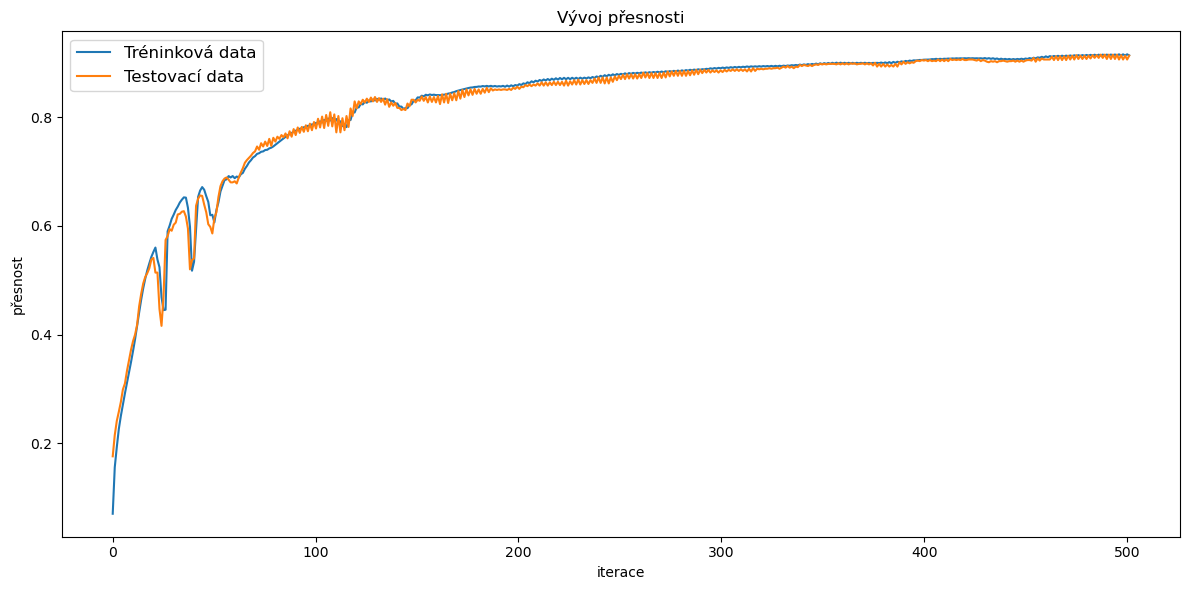

In [12]:
%matplotlib inline
pocet_presnosti = presnosti.size
osa_x = np.linspace(0, pocet_presnosti, pocet_presnosti)
plt.figure(figsize=(12,6))
plt.plot(osa_x, presnosti)
plt.plot(osa_x, presnosti_test)
plt.xlabel('iterace')
plt.ylabel('přesnost')
plt.title('Vývoj přesnosti')
plt.legend(['Tréninková data', 'Testovací data'], fontsize="large")
plt.tight_layout()

Odhad:  [1]
Správné:  1


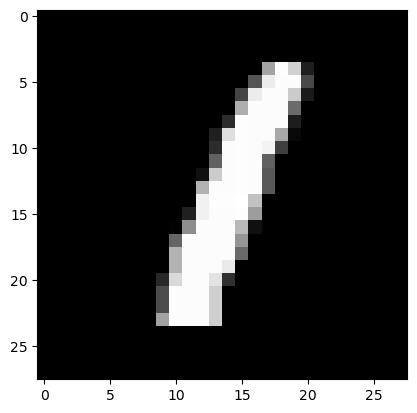

Odhad:  [2]
Správné:  3


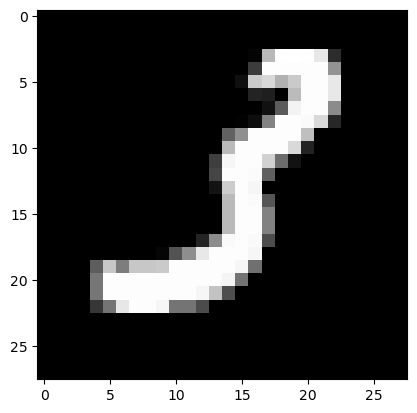

Odhad:  [9]
Správné:  9


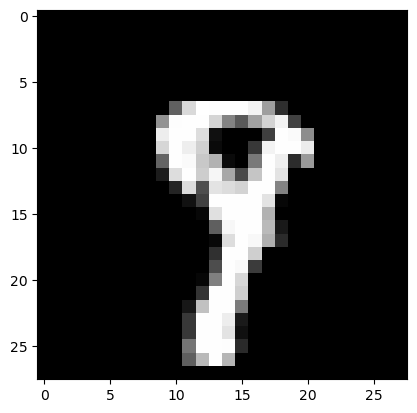

Odhad:  [3]
Správné:  3


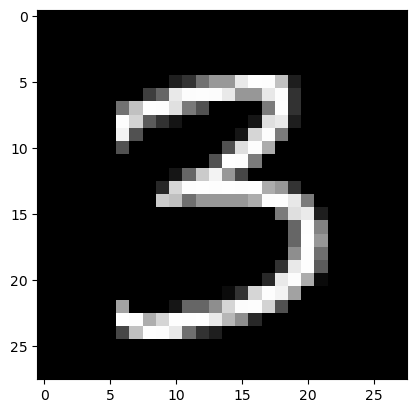

Odhad:  [6]
Správné:  6


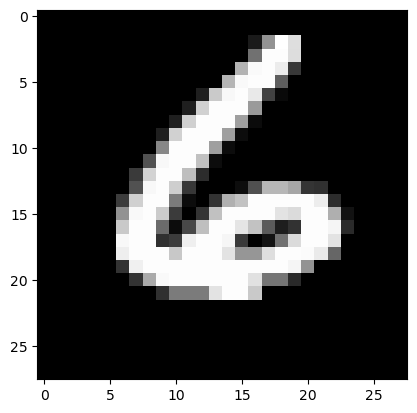

Odhad:  [3]
Správné:  3


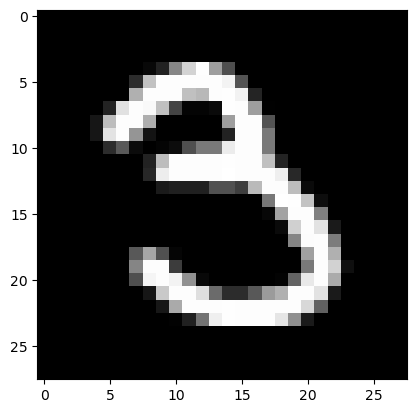

Odhad:  [6]
Správné:  6


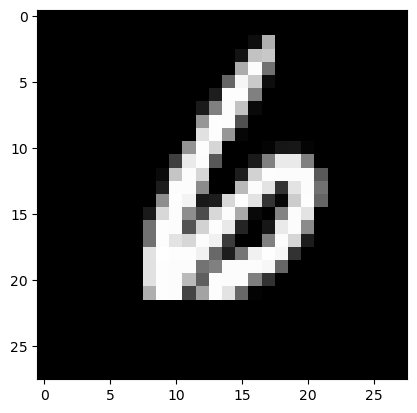

Odhad:  [0]
Správné:  0


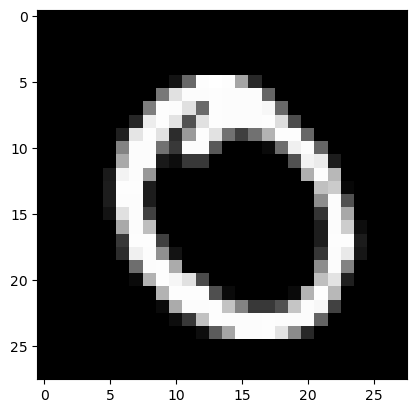

Odhad:  [1]
Správné:  1


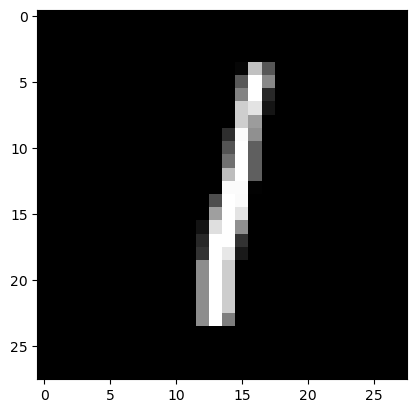

Odhad:  [2]
Správné:  2


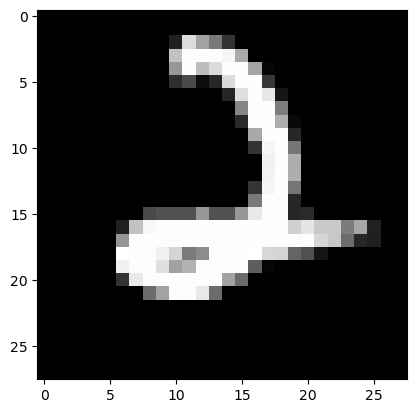

In [14]:
rozsah = 10
a = np.random.randint(0,Y_dev.size - rozsah)
for i in range(a, a + rozsah):
    test_samostatne(i, W1, b1, W2, b2, W3, b3, X_dev, Y_dev)

In [15]:
presnost = test(W1, b1, W2, b2, W3, b3, X_dev, Y_dev)
print('Přesnost: ', round(presnost * 100, 2) ,  ' %')

Přesnost:  91.3  %
